
#  オペレーティングシステム 演習 12
#  先読み

名前と学生証番号を書け. Enter your name and student ID.

 * 名前 Name:
 * 学生証番号 Student ID:

# 1. はじめに: 逐次(シーケンシャル)アクセス vs ランダムアクセス
* ファイルがキャッシュにあるか否かで性能が異なることを見たが, <font color="blue">ファイルがキャッシュにない場合の性能もアクセスパターンによって大きく異なる</font>
* 大雑把に言って, <font color="blue">「逐次的なアクセス」vs.「ランダムなアクセス」で大きく性能が異なる</font>
* 以下は上記のファイル読み込みを変更し, 逐次 vs. ランダムを引数で切り替えられるようにしたもの(第5引数が追加されており, 0ならば逐次, それ以外の場合それを乱数の種として読み出す順番をシャッフルする. どちらの場合も最終的に同じ場所を読み出す)

In [1]:
%%writefile read_file_seq_or_random.c
#define _GNU_SOURCE             /* See feature_test_macros(7) */
#include <assert.h>
#include <err.h>
#include <fcntl.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/time.h>
#include <unistd.h>

/* イベントの種類 */
typedef enum {
  ek_read_enter,
  ek_read_return,
} event_kind_t;

/* 1イベントの記録 */
typedef struct {
  double t;                     /* 時刻 */
  event_kind_t kind;            /* イベントの種類(read呼び出し, read復帰, etc.) */
  size_t offset;                /* 読んだ場所 */
  size_t size;                  /* 読んだサイズ */
} record_t;

/* 全イベントの記録 */
typedef struct {
  long n_records;              /* 配列aのサイズ */
  long i;                       /* 次に書き込むインデクス */
  record_t * a;                 /* recordの配列 */
  int fd;                       /* ファイルディスクリプタ */
  long data_sz;                 /* ファイル(使う部分)のサイズ */
} records_t;

const char * event_kind_string(event_kind_t k) {
  switch (k) {
  case ek_read_enter:
    return "read_enter";
  case ek_read_return:
    return "read_return";
  default:
    assert(0);
  }
}

const long page_sz = 4096;

/* n_records分の記録を保持できるrecords_tを作る */
records_t * mk_records(long n_records
                       ) {
  record_t * a = (record_t *)malloc(sizeof(record_t) * n_records);
  memset(a, 0, sizeof(record_t) * n_records);
  /* records_tの割当て */
  records_t * R = (records_t *)malloc(sizeof(records_t));
  R->n_records = n_records;
  R->i = 0;
  R->a = a;
  return R;
}

void destroy_records(records_t * R) {
  free((records_t *)R);
}

/* 時刻を返す */
double cur_time() {
  struct timeval tp[1];
  gettimeofday(tp, 0);
  double t = tp->tv_sec + 1.0e-6 * tp->tv_usec;
  return t;
}

/* 1イベントの記録 */
void record_event(records_t * R, event_kind_t k, size_t offset, size_t size) {
  long i = __sync_fetch_and_add(&R->i, 1);
  assert(i < R->n_records);
  R->a[i].t = cur_time();
  R->a[i].kind = k;
  R->a[i].offset = offset;
  R->a[i].size = size;
}

/* 全イベントの記録を標準出力へ表示 */
void print_records(records_t * R) {
  long m = R->i;
  for (long i = 0; i < m; i++) {
    printf("%f %s %ld %ld\n",
           R->a[i].t - R->a[0].t,
           event_kind_string(R->a[i].kind),
           R->a[i].offset,
           R->a[i].size);
  }
}

/* 長さ n_blocks の配列 a を返す. 
   a[i] は i 番目に読むべきファイルの位置.
   seed == 0 の場合 -> 逐次 
   seed != 0 の場合 -> ランダム */
ssize_t * make_offsets(int block_sz, int n_blocks, long seed) {
  ssize_t * a = (ssize_t *)malloc(sizeof(ssize_t) * n_blocks);
  int i = 0;
  for (i = 0; i < n_blocks; i++) {
    a[i] = i * block_sz;
  }
  if (seed) {
    unsigned short rg[3] = {(unsigned short)(seed >> 16),
                            (unsigned short)(seed >> 8),
                            (unsigned short)(seed >> 0)};
    /* 配列のかき混ぜ (10 * 要素数回くらい, 適当な2要素を入れ替え) */
    for (i = 0; i < 10 * n_blocks; i++) {
      int j = nrand48(rg) % n_blocks;
      int k = nrand48(rg) % n_blocks;
      int t = a[j];
      a[j] = a[k];
      a[k] = t;
    }
  }
  return a;
}

/* szバイトぴったり読む. その前にEOFになったらエラー */
long read_sz_at(int fd, char * buf, off_t offset, size_t sz, records_t * R) {
  //if (lseek(fd, offset, SEEK_SET) == -1) err(1, "lseek");
  record_event(R, ek_read_enter, offset, sz);
  size_t rd = 0;
  while (rd < sz) {
    ssize_t x = pread(fd, buf + rd, sz - rd, offset + rd);
    if (x == -1) err(1, "read");
    assert(x > 0);
    rd += x;
  }
  assert(rd == sz);
  size_t begin_offset = offset + page_sz - 1;
  begin_offset -= begin_offset % page_sz;
  long s = 0;
  for (size_t o = begin_offset; o < offset + sz; o += page_sz) {
    s += buf[o - offset];
  }
  record_event(R, ek_read_return, offset, sz);
  return s;
}

/* 10m, 100k みたいな文字列を読んで数に変換
   e.g., 10k -> 10 * 1024 */
long parse_size(char * s) {
  long n = strlen(s);
  long unit = -1;
  assert(n > 0);
  switch (s[n - 1]) {
  case 'K' :
  case 'k' :
    unit = 1024L;
    break;
  case 'M' :
  case 'm' :
    unit = 1024L * 1024L;
    break;
  case '0' ... '9' :
    unit = 1L;
    break;
  case 'G' :
  case 'g' :
    fprintf(stderr, "do you mean GB? don't be so aggressive\n");
    break;
  case 'T' :
  case 't' :
    fprintf(stderr, "do you mean TB? don't be so aggressive\n");
    break;
  default:
    fprintf(stderr, "invalid unit (%c) specified\n", s[n - 1]);
    break;
  }
  if (unit == -1) return -1;
  long x = atol(s);
  assert(x > 0);
  return x * unit;
}

/* 
./read_file_2 FILE SZ N_TIMES BLK_SZ SEED
 */
int main(int argc, char ** argv) {
  int i = 1;
  char * const filename = (argc > i ? argv[i] : "data.bin"); i++;
  /* 使うデータサイズ (ファイルの先頭から; MB単位) */
  const long data_sz_   = (argc > i ? parse_size(argv[i]) : parse_size("64m")); i++;
  /* ファイル全体を読む周回数 */
  const long n_times    = (argc > i ? atol(argv[i]) : 3); i++;
  /* read一回で読む量 */
  const long block_sz   = (argc > i ? parse_size(argv[i]) : parse_size("4k")); i++;
  /* 乱数 seed (0の場合は逐次) */
  const long seed       = (argc > i ? atol(argv[i]) : 0); i++;
  /* ブロック数 (中途半端は切り捨て) */
  const long n_blocks   = data_sz_ / block_sz;
  const long data_sz    = block_sz * n_blocks;
  /* 読み出すオフセットを作成 */
  const long n_records  = 2 * n_blocks * n_times;
  ssize_t * const offsets = make_offsets(block_sz, n_blocks, seed);
  records_t * const R = mk_records(n_records);

  fprintf(stderr, "read %ld bytes %ld times, %ld bytes at a time\n",
          data_sz, n_times, block_sz); fflush(stderr);
  for (long i = 0; i < n_times; i++) {
    fprintf(stderr, "%ld th read starts\n", i); fflush(stderr);
    const double t0 = cur_time();
    const int fd = open(filename, O_RDONLY);
    if (fd == -1) err(1, "open");
    long s = 0;
    {
      char * const buf = (char *)malloc(block_sz);
      if (!buf) err(1, "malloc");
      for (long j = 0; j < n_blocks; j++) {
        if (j >= 0) {
          s += read_sz_at(fd, buf, offsets[j], block_sz, R);
        }
      }
      free(buf);
    }
    if (close(fd) == -1) err(1, "close");
    double t1 = cur_time();
    double dt = t1 - t0;
    fprintf(stderr, "took %f sec, %f MB/sec, sum = %ld\n",
            dt, data_sz / (1024.0 * 1024.0) / dt, s);
    fflush(stderr);
  }
  print_records(R);
  destroy_records(R);
  return 0;
}

Writing read_file_seq_or_random.c


In [2]:
gcc -Wall -O3 -o read_file_seq_or_random read_file_seq_or_random.c

* なお, 大きなデータをランダムに読み出すと, HDDの場合, 相当待たされることになるので以下は小さめ(64MB)で実験する

* <font color="blue">64MBを4KBずつ逐次</font>読み出し(第5引数=0)

* <font color="red">注:</font> 以下でデータ(`../os11_cache/data.bin`)やプログラム(`../os11_cache/drop_cache`)がないというエラーになったら, 前回のJupyter notebook (os11_cache) の適切なセルを実行すること

In [3]:
data=../os11_cache/data.bin
../os11_cache/drop_cache ${data}
./read_file_seq_or_random ${data} 64m 3 4k 0 > s.dat

read 67108864 bytes 3 times, 4096 bytes at a time
0 th read starts
took 0.104587 sec, 611.930280 MB/sec, sum = -11020
1 th read starts
took 0.019215 sec, 3330.712659 MB/sec, sum = -11020
2 th read starts
took 0.018798 sec, 3404.640252 MB/sec, sum = -11020


* <font color="blue">64MBを4KBずつランダム</font>読み出し(第5引数=123456 (0以外))

In [4]:
data=../os11_cache/data.bin
../os11_cache/drop_cache ${data}
./read_file_seq_or_random ${data} 64m 3 4k 123456 > s.dat

read 67108864 bytes 3 times, 4096 bytes at a time
0 th read starts
took 1.310013 sec, 48.854484 MB/sec, sum = -11020
1 th read starts
took 0.021313 sec, 3002.868860 MB/sec, sum = -11020
2 th read starts
took 0.017728 sec, 3610.089918 MB/sec, sum = -11020



# 2. 逐次的なアクセスはなぜ速いのか?
* まずはランダムアクセスの可視化をしてみよう
* 以下はreadの呼び出し前と後を曲線で表示しており, <font color="blue">グラフの拡大表示を繰り返していくと, 各読み出し(readシステムコール)にかかった時間がわかるのでやってみよ</font>
* 以下は時間節約のため16MBを1回だけ読み出す
* 各4KBの読み出しにかかった時間がどのくらいかを見てみよ

In [5]:
data=../os11_cache/data.bin
../os11_cache/drop_cache ${data}
./read_file_seq_or_random ${data} 16m 1 4k 123456 > r.dat

read 16777216 bytes 1 times, 4096 bytes at a time
0 th read starts
took 0.322853 sec, 49.558144 MB/sec, sum = 1315


#  可視化

In [6]:
#!/usr/bin/python3
import pdb
import re
import sqlite3
import sys
import matplotlib.pyplot as plt
import numpy as np

def process_line(filename, line, exprs, row_exprs, V, K, R):
    for e in exprs:
        m = e.search(line)
        if m:
            V.update(m.groupdict())
            dK = set(V.keys()).difference(set(K))
            K.extend(list(dK))
    for r in row_exprs:
        if r.search(line):
            R.append(V.copy())
            break

def read_dats(result_dats, exprs, row_exprs):
    K = []
    R = []
    for result_dat in result_dats:
        V = {"file" : result_dat}
        with open(result_dat) as fp:
            for line in fp:
                process_line(result_dat, line, exprs, row_exprs, V, K, R)
    return K, R

def sqlite3_val(x):
    if x is None:
        return None
    try:
        return int(x)
    except ValueError:
        pass
    try:
        return float(x)
    except ValueError:
        pass
    try:
        return float(x)
    except ValueError:
        pass
    return x

def dats_to_db(result_dats, exprs, row_exprs):
    K, R = read_dats(result_dats, exprs, row_exprs)
    co = sqlite3.connect(":memory:")
    co.execute("create table a({cols})".format(cols=",".join(K)))
    insert = ("insert into a({cols}) values({placeholders})"
              .format(cols=",".join(K), placeholders=",".join(["?"] * len(K))))
    for r in R:
        co.execute(insert, tuple([sqlite3_val(r.get(k)) for k in K]))
    co.commit()
    return co

def draw(files, exprs, row_exprs, cmds, start=0, end=-1,
         xlabel=None, ylabel=None, col_is_x=False):
    co = dats_to_db(files, exprs, row_exprs)
    fig, ax = plt.subplots()
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    for cmd,kw in cmds:
        res = list(co.execute(cmd))
        res = res[start:end]
        if len(res) == 0:
            continue
        if len(res[0]) == 1:
            res = list(enumerate(x for x, in res))
            if col_is_x:
                res = [(y,x) for x,y in res]
        x = np.array([x for x,_ in res])
        y = np.array([y for _,y in res])
        plt.plot(x, y, '-o', **kw)
    plt.legend()
    plt.show()
    co.close()

def graph(files, start=0, end=-1):
    exprs = [
        re.compile(r"(?P<t>\d+\.\d+) (?P<event>.*?) (?P<offset>\d+) (?P<size>\d+)"),
    ]
    row_exprs = exprs[-1:]
    draw(files, exprs, row_exprs,
         [('select 1000*t from a where event="%s"' % x, dict(label="%s" % x))
          for x in ["read_ahead_enter", "read_ahead_return", "read_enter", "read_return"]],
         start=start, end=end,
         xlabel="count", ylabel="time [ms]")



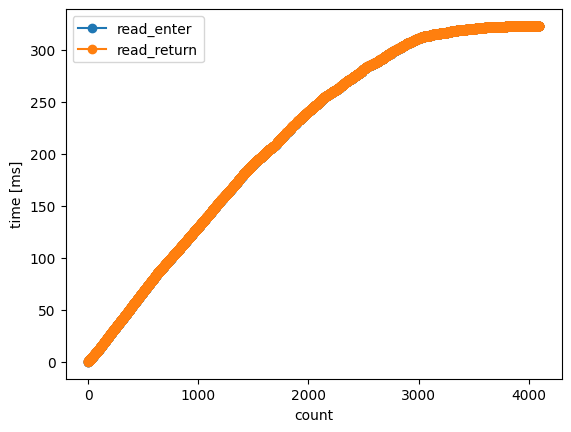

In [7]:
graph(["r.dat"])

* 一部を拡大するために, start=, end= という引数を指定する
* 以下を適宜変更して望むところを拡大する

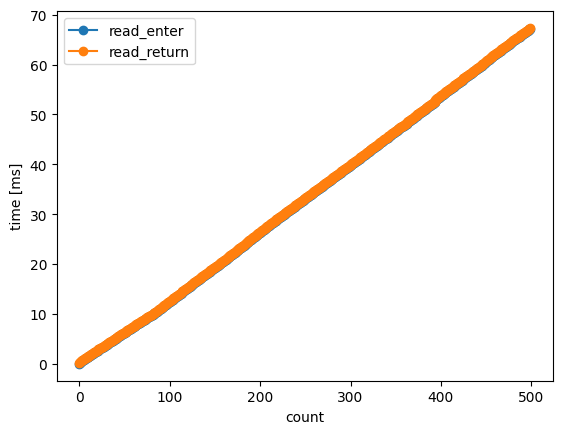

In [8]:
graph(["r.dat"], start=0, end=500)

* 逐次アクセスと比べる

In [9]:
data=../os11_cache/data.bin
../os11_cache/drop_cache ${data}
./read_file_seq_or_random ${data} 16m 1 4k 0 > s.dat

read 16777216 bytes 1 times, 4096 bytes at a time
0 th read starts
took 0.022761 sec, 702.953523 MB/sec, sum = 1315


* 可視化
  * 特にはじめの方を, 2本の線の間隔がわかるようになるまで拡大表示てみよ

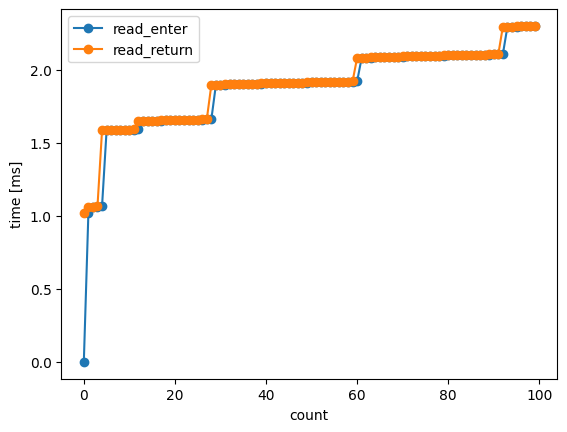

In [14]:
# graph(["s.dat"])
graph(["s.dat"], start=0, end=100)

* <font color="blue">ここからOSが何をしているのかの片鱗が見て取れる</font>
* ある<font color="blue">4KBのアクセスが終わるとその後しばらくのreadには, ほとんど時間がかからずに終了</font>していることが見て取れる(`read_enter`と`read_return`にほとんど隙間がない)
* それは, それらの(すぐに終わる)readの発行時にはすでにそのデータがキャッシュ(メモリ)上に載っているからであり, それはOSが4KBの読み出しであっても, 「逐次的な読み出し」を察知するとその先のデータも一度に読み出(先読み)しているからであると考えられる
* 実験結果から最大で32回分, したがって128KBくらいの読み出しを一度に出していると考えられる
* 従ってランダムな(飛び飛びの)アクセスであっても一度にその程度の量を読み出すのであれば逐次読み出しと大差のない性能が得られると予想され, 実際そのとおりの結果になる

* 128MBを逐次またはランダムに読み出す. ただし一度に128KB程度読み出す

In [15]:
data=../os11_cache/data.bin
../os11_cache/drop_cache ${data}
./read_file_seq_or_random ${data} 128m 1 128k 0 > s.dat
../os11_cache/drop_cache ${data}
./read_file_seq_or_random ${data} 128m 1 128k 123456 > r.dat

read 134217728 bytes 1 times, 131072 bytes at a time
0 th read starts
took 0.192731 sec, 664.137610 MB/sec, sum = -6773
read 134217728 bytes 1 times, 131072 bytes at a time
0 th read starts
took 0.275088 sec, 465.305526 MB/sec, sum = -6773



# 3. アプリケーション設計に対する指針
* 逐次読み出し と ランダム読み出しの性能の違いはデータ処理アプリケーション設計の際にも重要な設計指針を与える
* 勿論大きくは, 「データを読み出す量を最小にする」ことが効率化につながるわけだが, 一度に読み出すデータをある程度以下(2次記憶装置の「遅延 * 最大転送速度」に比べて極端に少なすぎる値)にしても, 2次記憶装置からの読み出し高速化にはつながらない
* 例えば平均遅延が5ms, 最大の転送速度が100MB/secのHDDは,
  * 1バイトの読み出しに5msかかる一方,
  * 100KB の読み出しに 5ms + 100KB/100MB = 5ms + 1ms = 6ms しかかからない, ということになる
* したがってディスク上で連続した100KB程度のデータであればその中のごく一部を読み出すような節約はあまり意味がないことになる
* キャッシュに載っているデータであれば意味があるので, キャッシュの効果までを含めた, 効率的なデータ構造は自明な問題ではない

* このことは大規模データからの検索やマイニングのようなアプリケーションで特に問題となる
* 索引(木構造やハッシュ表)を使ってアクセスするデータを減らす(結果的にアクセスがランダムになりがち)のが良いのか, 全てのデータを逐次的に読んでしまうのが良いのか, という選択を迫られる

# 4. ランダムアクセスを高速にすることは可能か?
* ディスク上で散らばった細かいデータを高速に読み出すことは可能なのだろうか?
* ランダムな読み出しが遅い理由は, 転送速度が「1回の読み出し量 / 遅延」で律速されるからである
* 性能を向上させる基本的な手段は複数のアクセスを並行して行うことである.
* 以下の方法で実際にこれで性能が向上するかどうかは2次記憶装置の特性に大きく依存する
* 複数の(バラバラな場所に対する)アクセスを複数, 並行して処理することができる装置であれば性能向上が見込める

* たとえ話
  * 引っ越しで, 大量の荷物を運びたい
  * 荷物は大量で, 1台の車だと何往復もする必要がある
  * 全部の荷物を運び終えるのに一台の車をビュンビュン飛ばして走る方法(同じ時間で往復できる数を増やす)もあるが, 公道ではすぐに限界が来るだろう
  * そうではなくて何台もの車を同時に走らせれば運び終えるまでの時間は短くなる

# 5. readahead
* <font color="blue">readaheadはこれから必要となる領域をOSに指示するAPIで, OSがファイルの指定された領域をキャッシュまで読み込む効果を持つ</font>
* man readaheadを参照
* readと異なり, データの到着を待たないため, 複数の要求をどんどん発行することができる
* 以下は第6引数で, 何回分の読み出しをreadahead (先出し)しておくかを指定する

In [16]:
%%writefile read_file_ahead.c
#define _GNU_SOURCE             /* See feature_test_macros(7) */
#include <assert.h>
#include <err.h>
#include <fcntl.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/time.h>
#include <unistd.h>

/* イベントの種類 */
typedef enum {
  ek_read_enter,
  ek_read_return,
  ek_read_ahead_enter,
  ek_read_ahead_return,
} event_kind_t;

/* 1イベントの記録 */
typedef struct {
  double t;                     /* 時刻 */
  event_kind_t kind;            /* イベントの種類(read呼び出し, read復帰, etc.) */
  size_t offset;                /* 読んだ場所 */
  size_t size;                  /* 読んだサイズ */
} record_t;

/* 全イベントの記録 */
typedef struct {
  long n_records;              /* 配列aのサイズ */
  long i;                       /* 次に書き込むインデクス */
  record_t * a;                 /* recordの配列 */
  int fd;                       /* ファイルディスクリプタ */
  long data_sz;                 /* ファイル(使う部分)のサイズ */
} records_t;

const char * event_kind_string(event_kind_t k) {
  switch (k) {
  case ek_read_enter:
    return "read_enter";
  case ek_read_return:
    return "read_return";
  case ek_read_ahead_enter:
    return "read_ahead_enter";
  case ek_read_ahead_return:
    return "read_ahead_return";
  default:
    assert(0);
  }
}

const long page_sz = 4096;

/* n_records分の記録を保持できるrecords_tを作る */
records_t * mk_records(long n_records
                       ) {
  record_t * a = (record_t *)malloc(sizeof(record_t) * n_records);
  memset(a, 0, sizeof(record_t) * n_records);
  /* records_tの割当て */
  records_t * R = (records_t *)malloc(sizeof(records_t));
  R->n_records = n_records;
  R->i = 0;
  R->a = a;
  return R;
}

void destroy_records(records_t * R) {
  free((records_t *)R);
}

/* 時刻を返す */
double cur_time() {
  struct timeval tp[1];
  gettimeofday(tp, 0);
  double t = tp->tv_sec + 1.0e-6 * tp->tv_usec;
  return t;
}

/* 1イベントの記録 */
void record_event(records_t * R, event_kind_t k, size_t offset, size_t size) {
  long i = __sync_fetch_and_add(&R->i, 1);
  assert(i < R->n_records);
  R->a[i].t = cur_time();
  R->a[i].kind = k;
  R->a[i].offset = offset;
  R->a[i].size = size;
}

/* 全イベントの記録を標準出力へ表示 */
void print_records(records_t * R) {
  long m = R->i;
  for (long i = 0; i < m; i++) {
    printf("%f %s %ld %ld\n",
           R->a[i].t - R->a[0].t,
           event_kind_string(R->a[i].kind),
           R->a[i].offset,
           R->a[i].size);
  }
}

/* 長さ n_blocks の配列 a を返す. 
   a[i] は i 番目に読むべきファイルの位置.
   seed == 0 の場合 -> 逐次 
   seed != 0 の場合 -> ランダム */
ssize_t * make_offsets(int block_sz, int n_blocks, long seed) {
  ssize_t * a = (ssize_t *)malloc(sizeof(ssize_t) * n_blocks);
  int i = 0;
  for (i = 0; i < n_blocks; i++) {
    a[i] = i * block_sz;
  }
  if (seed) {
    unsigned short rg[3] = {(unsigned short)(seed >> 16),
                            (unsigned short)(seed >> 8),
                            (unsigned short)(seed >> 0)};
    /* 配列のかき混ぜ (10 * 要素数回くらい, 適当な2要素を入れ替え) */
    for (i = 0; i < 10 * n_blocks; i++) {
      int j = nrand48(rg) % n_blocks;
      int k = nrand48(rg) % n_blocks;
      int t = a[j];
      a[j] = a[k];
      a[k] = t;
    }
  }
  return a;
}

/* ファイルfdの [offset, offset+sz) の範囲をreadahead */
void read_ahead(int fd, off64_t offset, size_t sz, records_t * R) {
  record_event(R, ek_read_ahead_enter, offset, sz);
  ssize_t r = readahead(fd, offset, sz);
  if (r == -1) err(1, "readahead");
  record_event(R, ek_read_ahead_return, offset, sz);
}

/* szバイトぴったり読む. その前にEOFになったらエラー */
long read_sz_at(int fd, char * buf, off_t offset, size_t sz, records_t * R) {
  //if (lseek(fd, offset, SEEK_SET) == -1) err(1, "lseek");
  record_event(R, ek_read_enter, offset, sz);
  size_t rd = 0;
  while (rd < sz) {
    ssize_t x = pread(fd, buf + rd, sz - rd, offset + rd);
    if (x == -1) err(1, "read");
    assert(x > 0);
    rd += x;
  }
  assert(rd == sz);
  size_t begin_offset = offset + page_sz - 1;
  begin_offset -= begin_offset % page_sz;
  long s = 0;
  for (size_t o = begin_offset; o < offset + sz; o += page_sz) {
    s += buf[o - offset];
  }
  record_event(R, ek_read_return, offset, sz);
  return s;
}

/* 10m, 100k みたいな文字列を読んで数に変換
   e.g., 10k -> 10 * 1024 */
long parse_size(char * s) {
  long n = strlen(s);
  long unit = -1;
  assert(n > 0);
  switch (s[n - 1]) {
  case 'K' :
  case 'k' :
    unit = 1024L;
    break;
  case 'M' :
  case 'm' :
    unit = 1024L * 1024L;
    break;
  case '0' ... '9' :
    unit = 1L;
    break;
  case 'G' :
  case 'g' :
    fprintf(stderr, "do you mean GB? don't be so aggressive\n");
    break;
  case 'T' :
  case 't' :
    fprintf(stderr, "do you mean TB? don't be so aggressive\n");
    break;
  default:
    fprintf(stderr, "invalid unit (%c) specified\n", s[n - 1]);
    break;
  }
  if (unit == -1) return -1;
  long x = atol(s);
  assert(x > 0);
  return x * unit;
}

/* 
./read_file_3 FILE SZ N_TIMES BLK_SZ SEED N_READAHEADS
 */
int main(int argc, char ** argv) {
  int i = 1;
  char * const filename = (argc > i ? argv[i] : "data.bin"); i++;
  /* 使うデータサイズ (ファイルの先頭から; MB単位) */
  const long data_sz_   = (argc > i ? parse_size(argv[i]) : parse_size("64m")); i++;
  /* ファイル全体を読む周回数 */
  const long n_times    = (argc > i ? atol(argv[i]) : 3); i++;
  /* read一回で読む量 */
  const long block_sz   = (argc > i ? parse_size(argv[i]) : parse_size("4k")); i++;
  /* 乱数 seed (0の場合は逐次) */
  const long seed       = (argc > i ? atol(argv[i]) : 0); i++;
  /* 先読みする数 */
  const long n_aheads   = (argc > i ? atol(argv[i]) : 0); i++;
  /* ブロック数 (中途半端は切り捨て) */
  const long n_blocks   = data_sz_ / block_sz;
  const long data_sz    = block_sz * n_blocks;
  /* 読み出すオフセットを作成 */
  const long n_records  = 4 * n_blocks * n_times;
  ssize_t * const offsets = make_offsets(block_sz, n_blocks, seed);
  records_t * const R = mk_records(n_records);

  fprintf(stderr, "read %ld bytes %ld times, %ld bytes at a time\n",
          data_sz, n_times, block_sz); fflush(stderr);
  for (long i = 0; i < n_times; i++) {
    fprintf(stderr, "%ld th read starts\n", i); fflush(stderr);
    const double t0 = cur_time();
    const int fd = open(filename, O_RDONLY);
    if (fd == -1) err(1, "open");
    long s = 0;
    {
      char * const buf = (char *)malloc(block_sz);
      if (!buf) err(1, "malloc");
      /* n_aheads回分のreadahead */
      for (long j = -n_aheads; j < n_blocks; j++) {
        if (j >= 0) {
          s += read_sz_at(fd, buf, offsets[j], block_sz, R);
        }
        if (n_aheads > 0 && j + n_aheads < n_blocks) {
          read_ahead(fd, offsets[j + n_aheads], block_sz, R);
        }
      }
      free(buf);
    }
    if (close(fd) == -1) err(1, "close");
    double t1 = cur_time();
    double dt = t1 - t0;
    fprintf(stderr, "took %f sec, %f MB/sec, sum = %ld\n",
            dt, data_sz / (1024.0 * 1024.0) / dt, s);
    fflush(stderr);
  }
  print_records(R);
  destroy_records(R);
  return 0;
}

Writing read_file_ahead.c


In [17]:
gcc -Wall -O3 -o read_file_ahead read_file_ahead.c

* 最後の引数 (p) をいろいろと変えて実行してみよ
  * p = 1 は1つだけreadaheadする(readaheadしたデータを直後にreadするので先読みの効果は殆ど無い)
  * p = 2 からは(装置により)効果が現れるはず. 措置が理想的に, 2つの読み出しを並行に(それぞれを単独の読み出しと同じ時間で)処理できるのなら性能が2倍になる
  * 一般に, <font color="blue">措置が理想的にp個の読み出しをほぼ並行に(それぞれを, 単独の読み出しと同じ時間で)処理できるのなら性能がp倍になる</font>

* <font color="blue">pを変えて観測してみよ</font>

In [41]:
data=../os11_cache/data.bin
../os11_cache/drop_cache ${data}
p=10
./read_file_ahead ${data} 16m 1 4k 123456 ${p} > r.dat

read 16777216 bytes 1 times, 4096 bytes at a time
0 th read starts
took 0.188480 sec, 84.889581 MB/sec, sum = 1315


* 可視化

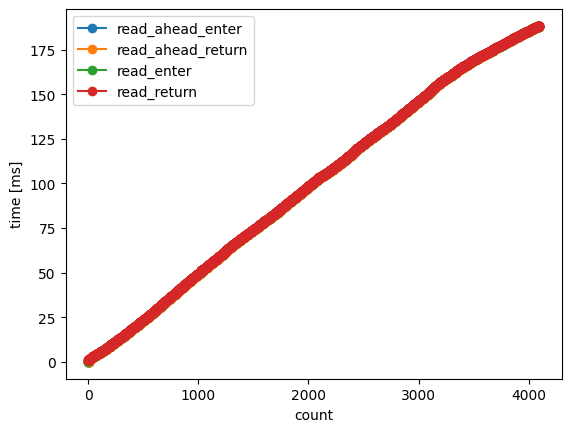

In [42]:
graph(["r.dat"])

# 6. 複数スレッドで読み込み
* readaheadを使う代わりに複数のスレッドで読み出すことでも, 複数の読み出し要求を並行して出すことができる
* 以下は読み出し部分をOpenMPで並列化したもの

In [43]:
%%writefile read_file_thread.c
#define _GNU_SOURCE             /* See feature_test_macros(7) */
#include <assert.h>
#include <err.h>
#include <fcntl.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/time.h>
#include <unistd.h>

/* イベントの種類 */
typedef enum {
  ek_read_enter,
  ek_read_return,
  ek_read_ahead_enter,
  ek_read_ahead_return,
} event_kind_t;

/* 1イベントの記録 */
typedef struct {
  double t;                     /* 時刻 */
  event_kind_t kind;            /* イベントの種類(read呼び出し, read復帰, etc.) */
  size_t offset;                /* 読んだ場所 */
  size_t size;                  /* 読んだサイズ */
} record_t;

/* 全イベントの記録 */
typedef struct {
  long n_records;              /* 配列aのサイズ */
  long i;                       /* 次に書き込むインデクス */
  record_t * a;                 /* recordの配列 */
  int fd;                       /* ファイルディスクリプタ */
  long data_sz;                 /* ファイル(使う部分)のサイズ */
} records_t;

const char * event_kind_string(event_kind_t k) {
  switch (k) {
  case ek_read_enter:
    return "read_enter";
  case ek_read_return:
    return "read_return";
  case ek_read_ahead_enter:
    return "read_ahead_enter";
  case ek_read_ahead_return:
    return "read_ahead_return";
  default:
    assert(0);
  }
}

const long page_sz = 4096;

/* n_records分の記録を保持できるrecords_tを作る */
records_t * mk_records(long n_records
                       ) {
  record_t * a = (record_t *)malloc(sizeof(record_t) * n_records);
  memset(a, 0, sizeof(record_t) * n_records);
  /* records_tの割当て */
  records_t * R = (records_t *)malloc(sizeof(records_t));
  R->n_records = n_records;
  R->i = 0;
  R->a = a;
  return R;
}

void destroy_records(records_t * R) {
  free((records_t *)R);
}

/* 時刻を返す */
double cur_time() {
  struct timeval tp[1];
  gettimeofday(tp, 0);
  double t = tp->tv_sec + 1.0e-6 * tp->tv_usec;
  return t;
}

/* 1イベントの記録 */
void record_event(records_t * R, event_kind_t k, size_t offset, size_t size) {
  long i = __sync_fetch_and_add(&R->i, 1);
  assert(i < R->n_records);
  R->a[i].t = cur_time();
  R->a[i].kind = k;
  R->a[i].offset = offset;
  R->a[i].size = size;
}

/* 全イベントの記録を標準出力へ表示 */
void print_records(records_t * R) {
  long m = R->i;
  for (long i = 0; i < m; i++) {
    printf("%f %s %ld %ld\n",
           R->a[i].t - R->a[0].t,
           event_kind_string(R->a[i].kind),
           R->a[i].offset,
           R->a[i].size);
  }
}

/* 長さ n_blocks の配列 a を返す. 
   a[i] は i 番目に読むべきファイルの位置.
   seed == 0 の場合 -> 逐次 
   seed != 0 の場合 -> ランダム */
ssize_t * make_offsets(int block_sz, int n_blocks, long seed) {
  ssize_t * a = (ssize_t *)malloc(sizeof(ssize_t) * n_blocks);
  int i = 0;
  for (i = 0; i < n_blocks; i++) {
    a[i] = i * block_sz;
  }
  if (seed) {
    unsigned short rg[3] = {(unsigned short)(seed >> 16),
                            (unsigned short)(seed >> 8),
                            (unsigned short)(seed >> 0)};
    /* 配列のかき混ぜ (10 * 要素数回くらい, 適当な2要素を入れ替え) */
    for (i = 0; i < 10 * n_blocks; i++) {
      int j = nrand48(rg) % n_blocks;
      int k = nrand48(rg) % n_blocks;
      int t = a[j];
      a[j] = a[k];
      a[k] = t;
    }
  }
  return a;
}

/* ファイルfdの [offset, offset+sz) の範囲をreadahead */
void read_ahead(int fd, off64_t offset, size_t sz, records_t * R) {
  record_event(R, ek_read_ahead_enter, offset, sz);
  ssize_t r = readahead(fd, offset, sz);
  if (r == -1) err(1, "readahead");
  record_event(R, ek_read_ahead_return, offset, sz);
}

/* szバイトぴったり読む. その前にEOFになったらエラー */
long read_sz_at(int fd, char * buf, off_t offset, size_t sz, records_t * R) {
  //if (lseek(fd, offset, SEEK_SET) == -1) err(1, "lseek");
  record_event(R, ek_read_enter, offset, sz);
  size_t rd = 0;
  while (rd < sz) {
    ssize_t x = pread(fd, buf + rd, sz - rd, offset + rd);
    if (x == -1) err(1, "read");
    assert(x > 0);
    rd += x;
  }
  assert(rd == sz);
  size_t begin_offset = offset + page_sz - 1;
  begin_offset -= begin_offset % page_sz;
  long s = 0;
  for (size_t o = begin_offset; o < offset + sz; o += page_sz) {
    s += buf[o - offset];
  }
  record_event(R, ek_read_return, offset, sz);
  return s;
}

/* 10m, 100k みたいな文字列を読んで数に変換
   e.g., 10k -> 10 * 1024 */
long parse_size(char * s) {
  long n = strlen(s);
  long unit = -1;
  assert(n > 0);
  switch (s[n - 1]) {
  case 'K' :
  case 'k' :
    unit = 1024L;
    break;
  case 'M' :
  case 'm' :
    unit = 1024L * 1024L;
    break;
  case '0' ... '9' :
    unit = 1L;
    break;
  case 'G' :
  case 'g' :
    fprintf(stderr, "do you mean GB? don't be so aggressive\n");
    break;
  case 'T' :
  case 't' :
    fprintf(stderr, "do you mean TB? don't be so aggressive\n");
    break;
  default:
    fprintf(stderr, "invalid unit (%c) specified\n", s[n - 1]);
    break;
  }
  if (unit == -1) return -1;
  long x = atol(s);
  assert(x > 0);
  return x * unit;
}

/* 
OMP_NUM_THREADS=N ./read_file_4 FILE SZ N_TIMES BLK_SZ SEED
 */
int main(int argc, char ** argv) {
  int i = 1;
  char * const filename = (argc > i ? argv[i] : "data.bin"); i++;
  /* 使うデータサイズ (ファイルの先頭から; MB単位) */
  const long data_sz_   = (argc > i ? parse_size(argv[i]) : parse_size("64m")); i++;
  /* ファイル全体を読む周回数 */
  const long n_times    = (argc > i ? atol(argv[i]) : 3); i++;
  /* read一回で読む量 */
  const long block_sz   = (argc > i ? parse_size(argv[i]) : parse_size("4k")); i++;
  /* 乱数 seed (0の場合は逐次) */
  const long seed       = (argc > i ? atol(argv[i]) : 0); i++;
  /* 先読みする数 */
  const long n_aheads   = (argc > i ? atol(argv[i]) : 0); i++;
  /* ブロック数 (中途半端は切り捨て) */
  const long n_blocks   = data_sz_ / block_sz;
  const long data_sz    = block_sz * n_blocks;
  /* 読み出すオフセットを作成 */
  const long n_records  = 4 * n_blocks * n_times;
  ssize_t * const offsets = make_offsets(block_sz, n_blocks, seed);
  records_t * const R = mk_records(n_records);

  fprintf(stderr, "read %ld bytes %ld times, %ld bytes at a time\n",
          data_sz, n_times, block_sz); fflush(stderr);
  for (long i = 0; i < n_times; i++) {
    fprintf(stderr, "%ld th read starts\n", i); fflush(stderr);
    const double t0 = cur_time();
    const int fd = open(filename, O_RDONLY);
    if (fd == -1) err(1, "open");
    long s = 0;
#pragma omp parallel reduction(+:s)
    {
      char * const buf = (char *)malloc(block_sz);
      if (!buf) err(1, "malloc");
#pragma omp for schedule(dynamic)
      /* n_aheads回分のreadahead */
      for (long j = -n_aheads; j < n_blocks; j++) {
        if (j >= 0) {
          s += read_sz_at(fd, buf, offsets[j], block_sz, R);
        }
        if (n_aheads > 0 && j + n_aheads < n_blocks) {
          read_ahead(fd, offsets[j + n_aheads], block_sz, R);
        }
      }
      free(buf);
    }
    if (close(fd) == -1) err(1, "close");
    double t1 = cur_time();
    double dt = t1 - t0;
    fprintf(stderr, "took %f sec, %f MB/sec, sum = %ld\n",
            dt, data_sz / (1024.0 * 1024.0) / dt, s);
    fflush(stderr);
  }
  print_records(R);
  destroy_records(R);
  return 0;
}

Writing read_file_thread.c


In [44]:
gcc -Wall -O3 -fopenmp -o read_file_thread read_file_thread.c

* 実行 (スレッド数thをいろいろ変えて実行してみよ)

In [56]:
data=../os11_cache/data.bin
../os11_cache/drop_cache ${data}
th=2
OMP_NUM_THREADS=${th} ./read_file_thread ${data} 16m 1 4k 123456 > r.dat

read 16777216 bytes 1 times, 4096 bytes at a time
0 th read starts
took 0.192751 sec, 83.008678 MB/sec, sum = 1315


* 可視化

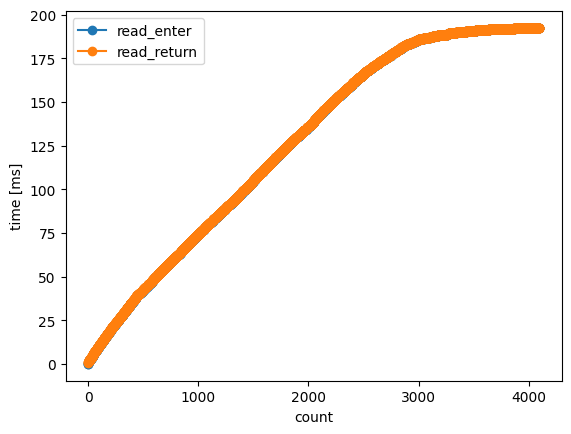

In [57]:
graph(["r.dat"])